In [1]:
import pandas as pd

data = pd.read_csv('./data.csv')

In [2]:
data = {
    'time' : data['time'],
    'tweet' : data['tweet']
}

In [3]:
df = pd.DataFrame(data)

In [4]:
df

,time,tweet
0,23:59:52,"Berikut adalah Rilis Pers, Pernyataan Sikap, K..."
1,23:59:49,#GejayanMemanggil... Mundurjok https://twitte...
2,23:59:45,Sesok banget #GejayanMemanggil pic.twitter.co...
3,23:59:37,"Okey, #GejayanMemanggil ✊"
4,23:59:32,Prediksi Keluaran Togel Hongkong Senin 23 Sept...
...,...,...
5080,09:02:47,"1998, gejayan menjadi sumbu yang menjatuhkan o..."
5081,08:53:26,23 september akan menjadi saksi bahwa kita tid...
5082,07:45:37,Done #GejayanMemanggil #Giveaway
5083,07:37:13,"Cinta itu pada kebenaran, bukan cinta kepada r..."


In [5]:
import re
def remove_links(text):
    url_pattern = re.compile(r'https:?//\S+|www.\S+|http:?//\S+|pic.twitter.com/\S+')
    
    cleaned_text = re.sub(url_pattern, '', text)
    
    return cleaned_text

In [6]:
df['tweet'] = df['tweet'].apply(remove_links)

In [7]:
def remove_tag_and_mention(text):
    pattern = re.compile(r'#\S+|@\S+')
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [8]:
df['tweet'] = df['tweet'].apply(remove_tag_and_mention)

In [9]:
def remove_symbol(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

In [10]:
df['tweet'] = df['tweet'].apply(remove_symbol)

In [11]:
df['tweet'] = df['tweet'].map(lambda x : x.lower() if isinstance(x, str) else x)

In [12]:
df['tweet']

0       berikut adalah rilis pers  pernyataan sikap  k...
1                                           mundurjok    
2                                         sesok banget   
3                                                okey    
4       prediksi keluaran togel hongkong senin 23 sept...
                              ...                        
5080    1998  gejayan menjadi sumbu yang menjatuhkan o...
5081    23 september akan menjadi saksi bahwa kita tid...
5082                                               done  
5083    cinta itu pada kebenaran  bukan cinta kepada r...
5084    memilih kongsi besar untuk mengatur pribumi la...
Name: tweet, Length: 5085, dtype: object

In [13]:
slangwords= {"@":"di", "abis" : "habis", "wtb": "beli", "masi":"masih", "wts":"jual", "wtt": "tukar", "bgt":"banget", "maks":"maksimal", 'yg':'yang'}

In [14]:
def slang_words_fix(text):
    words = text.split()
    fixedwords = []

    for word in words:
        if word.lower() in slangwords:
            fixedwords.append(slangwords[word.lower()])
        else:
            fixedwords.append(word)

    fixed_text = ' '.join(fixedwords)

    return fixed_text 

In [15]:
df['tweet'] = df['tweet'].apply(slang_words_fix)

In [16]:
df['tweet']

0       berikut adalah rilis pers pernyataan sikap kaj...
1                                               mundurjok
2                                            sesok banget
3                                                    okey
4       prediksi keluaran togel hongkong senin 23 sept...
                              ...                        
5080    1998 gejayan menjadi sumbu yang menjatuhkan or...
5081    23 september akan menjadi saksi bahwa kita tid...
5082                                                 done
5083    cinta itu pada kebenaran bukan cinta kepada re...
5084    memilih kongsi besar untuk mengatur pribumi la...
Name: tweet, Length: 5085, dtype: object

In [17]:
#filter kata yang kira kira tidak melenceng
kata_topik = ['gejayan', 'rezim', 'oligarki', 'suara', 'benar', 'orba', 'mahasiswa', 'yogyakarta', 'atur', 'orasi', 'gerakan', 'jogja', 'politik', 'rakyat', 'pemerintah', 'demo','rakyat', 'indonesia']

In [18]:
rows = []

for i, row in df.iterrows():
    tweet = row['tweet']
    for k in kata_topik:
        if k in tweet:
            rows.append(row)
            break

In [19]:
df_filtered = pd.DataFrame(rows)

In [20]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 5084
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    1404 non-null   object
 1   tweet   1404 non-null   object
dtypes: object(2)
memory usage: 32.9+ KB


In [21]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stopword_factory = StopWordRemoverFactory()
stemmer_factory = StemmerFactory()

stopword = stopword_factory.create_stop_word_remover()
stemmer = stemmer_factory.create_stemmer()

df_filtered['tweet'] = [stopword.remove(''.join(tweet)) for tweet in df_filtered['tweet']]
df_filtered['tweet'] = [stemmer.stem(tweet) for tweet in df_filtered['tweet']]

In [22]:
df_filtered['time'] = pd.to_datetime(df_filtered['time'], format='%H:%M:%S')

df_filtered['time'] = df_filtered['time'].dt.time


In [23]:
from datetime import time

first_limit = time(6, 0, 0)
second_limit = time(12, 0, 0)
third_limit = time(18, 0, 0)
fourth_limit = time(23, 59, 59)

quarter_day_1 = df_filtered[(df_filtered['time'] >= time(0, 0, 0)) & (df_filtered['time'] <= first_limit)].copy()
quarter_day_2 = df_filtered[(df_filtered['time'] > first_limit) & (df_filtered['time'] <= second_limit)].copy()
quarter_day_3 = df_filtered[(df_filtered['time'] > second_limit) & (df_filtered['time'] <= third_limit)].copy()
quarter_day_4 = df_filtered[(df_filtered['time'] > third_limit) & (df_filtered['time'] <= fourth_limit)].copy()

In [24]:
# Analisis topik untuk kuartal kedua 22 September 2019
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
second_quarter_day = quarter_day_2['tweet'].tolist()


In [25]:
second_quarter_day_vect = vectorizer.fit_transform(second_quarter_day)
feature_names = vectorizer.get_feature_names_out()

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda_2 = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch',max_iter=20, evaluate_every=3,  n_jobs=-1)

lda_2.fit(second_quarter_day_vect)

LatentDirichletAllocation(evaluate_every=3, max_iter=20, n_components=5,
                          n_jobs=-1, random_state=42)

In [27]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topik #{topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")

In [28]:
print(f"Topik yang Ditemukan ({5} Topik):")
display_topics(lda_2, feature_names, 5)

Topik yang Ditemukan (5 Topik):
Topik #1:
yogyakarta 19 23 besok dpr
Topik #2:
milik olah aku reformasi umur
Topik #3:
percaya gejayan suara orba sumbu
Topik #4:
kelas 23 turun jalan ketemu
Topik #5:
cinta rezim jiwa tahun pada




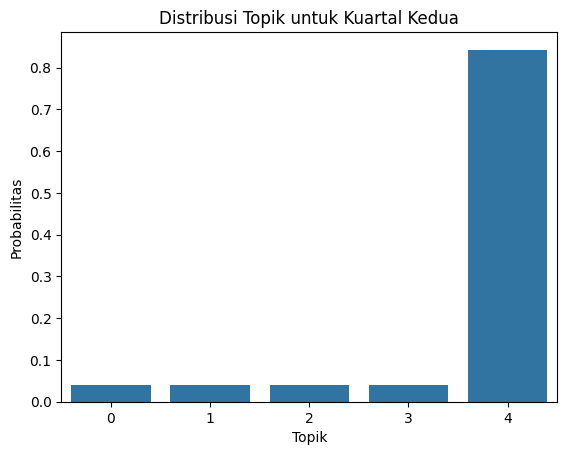

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

topic_dist = lda_2.transform(second_quarter_day_vect)

sns.barplot(x=list(range(topic_dist.shape[1])), y=topic_dist[0])
plt.title("Distribusi Topik untuk Kuartal Kedua")
plt.xlabel("Topik")
plt.ylabel("Probabilitas")
plt.show()

In [29]:
# Analisis topik untuk kuartal ketiga 22 September 2019
vectorizer3 = TfidfVectorizer()

third_quarter_day = quarter_day_3['tweet'].tolist()

In [30]:
third_quarter_day_vect = vectorizer3.fit_transform(third_quarter_day)
feature_names3 = vectorizer3.get_feature_names_out()

In [31]:
lda_3 = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch',max_iter=20, evaluate_every=3,  n_jobs=-1)

lda_3.fit(third_quarter_day_vect)

LatentDirichletAllocation(evaluate_every=3, max_iter=20, n_components=5,
                          n_jobs=-1, random_state=42)

In [32]:
print(f"Topik yang Ditemukan ({5} Topik):")
display_topics(lda_3, feature_names3, 5)

Topik yang Ditemukan (5 Topik):
Topik #1:
gejayan rakyat besok sama ketemu
Topik #2:
jogja gerak mahasiswa gejayan yogyakarta
Topik #3:
datang suara lawan rakyat jadi
Topik #4:
mahasiswa besok gejayan ayo suara
Topik #5:
baik indonesia gejayan jogja mahasiswa




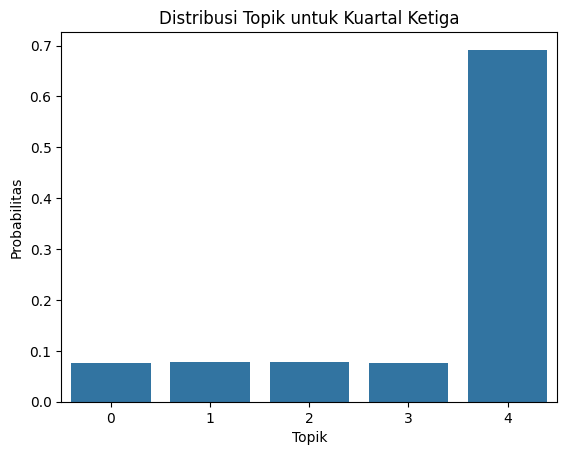

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

topic_dist = lda_3.transform(third_quarter_day_vect)

sns.barplot(x=list(range(topic_dist.shape[1])), y=topic_dist[0])
plt.title("Distribusi Topik untuk Kuartal Ketiga")
plt.xlabel("Topik")
plt.ylabel("Probabilitas")
plt.show()

In [33]:
# Analisis topik untuk kuartal keempat 22 September 2019
vectorizer4 = TfidfVectorizer()

fourth_quarter_day = quarter_day_4['tweet'].tolist()

In [34]:
fourth_quarter_day_vect = vectorizer4.fit_transform(fourth_quarter_day)
feature_names4 = vectorizer4.get_feature_names_out()

In [35]:
lda_4 = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch',max_iter=20, evaluate_every=3,  n_jobs=-1)

lda_4.fit(fourth_quarter_day_vect)

LatentDirichletAllocation(evaluate_every=3, max_iter=20, n_components=5,
                          n_jobs=-1, random_state=42)

In [36]:
print(f"Topik yang Ditemukan ({5} Topik):")
display_topics(lda_4, feature_names4, 5)

Topik yang Ditemukan (5 Topik):
Topik #1:
jogja mahasiswa gejayan rakyat indonesia
Topik #2:
gejayan besok mahasiswa aksi suara
Topik #3:
gejayan panggil jogja mahasiswa rakyat
Topik #4:
suara mahasiswa baik gejayan hidup
Topik #5:
mahasiswa gejayan indonesia sama apa




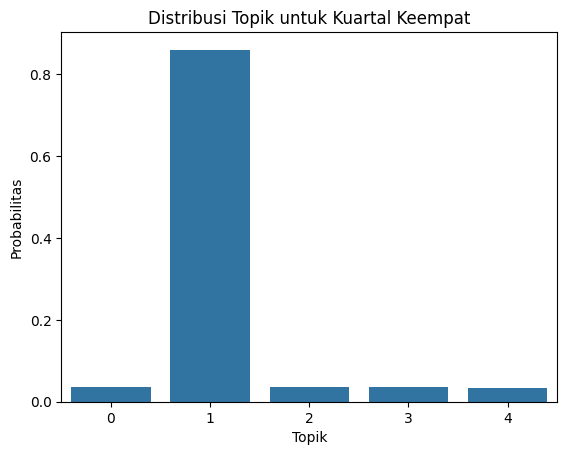

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

topic_dist = lda_4.transform(fourth_quarter_day_vect)

sns.barplot(x=list(range(topic_dist.shape[1])), y=topic_dist[0])
plt.title("Distribusi Topik untuk Kuartal Keempat")
plt.xlabel("Topik")
plt.ylabel("Probabilitas")
plt.show()